Virtual Acoustics and Immersive Audio Workshop - CCRMA Stanford University  
28.07.25 - Orchisama Das, Gloria Dal Santo
  
### L06: Binaural rendering

In this assignment we will 
- Analyze a given HRIR dataset in SOFA format
- Interpolate the HRIRs to a denser grid and save it in SOFA format
- Listen and compare both datasets in Reaper with SPARTA's binauralizer plugin with head tracking.

In [1]:
import numpy as np
from pathlib import Path
from loguru import logger
import matplotlib.pyplot as plt
from spatial_audio.sofa_parser import HRIRReader, HRIRWriter
from spatial_audio.hrtf import HRIRInterpolator, HRIRSet
from spatial_audio.plot import plot_points_on_sphere
from utils import unpack_coordinates, cart2sph

## Part 1
- Read the HRTF dataset with `HRIRReader`
- Plot the azimuth and elevation angles at which the HRIRs were measured on a spherical grid with the `spatial_audio.plot.plot_points_on_sphere()` function.
- Note the grid spacing between azimuth angles ($\theta_\text{grid}$) and elevation angles ($\phi_\text{grid}$). Verify that the grid is equiangular (same spacing between all azimuth and elevation angles).

2025-07-28 16:28:18.713 | INFO     | spatial_audio.sofa_parser:__init__:40 - None
2025-07-28 16:28:18.714 | INFO     | spatial_audio.sofa_parser:__init__:41 - Shape of the IRs is (684, 2, 200)


R = 2 receiver (set by ReceiverPosition of dimension RCI, RCM)
E = 1 emitter (set by EmitterPosition of dimension ECI, ECM)
M = 684 measurements (set by Data_IR of dimension MRN)
N = 200 samples (set by Data_IR of dimension MRN)
C = 3 coordinate dimensions, fixed
I = 1 single dimension, fixed
S = 0 maximum string length



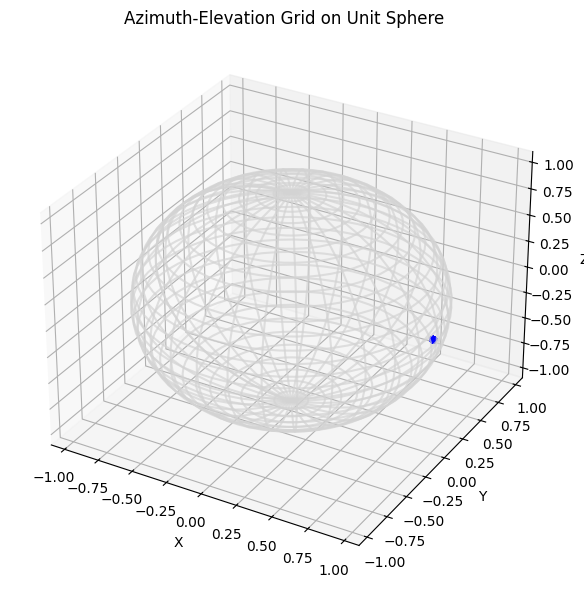

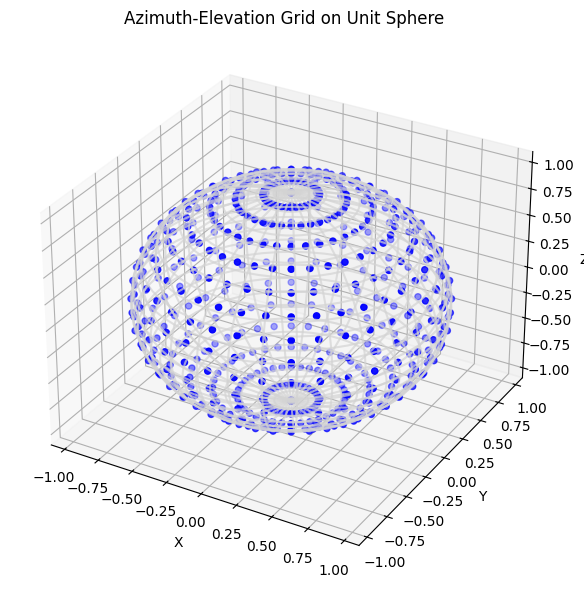

In [2]:
# Path to HRIR dataset
sofa_path = Path('../data/Week 2/hrtf/CIPIC_subject_119_equiangular_grid.sofa').resolve()

#### WRITE YOUR CODE HERE ####

# Create HRIRReader object
hrir_reader = HRIRReader(sofa_path)

# Read azimuth and elevation angles from the dataset
az1, el1, r1 = unpack_coordinates(hrir_reader.get_listener_view(coord_type="spherical"))
az2, el2, r2 = unpack_coordinates(hrir_reader.get_source_view(coord_type="spherical"))

# Plot the azimuth and elevation angles on a sphere by calling plot_points_on_sphere
plot_points_on_sphere(az1, el1)
plot_points_on_sphere(az2, el2)


### Part 2

See `src/spatial_audio/hrtf.py`. Create an `HRIRSet` dataclass from the dataset you have just read.

In [3]:
hrir_data = HRIRSet(hrir_reader.fs, hrir_reader.num_meas, hrir_reader.ir_length, hrir_reader.ir_data,
                    hrir_reader.listener_view, hrir_reader.listener_view_type, source_view=hrir_reader.get_source_view("spherical"))

### Part 3

- Complete the function `bilinear_interpolation(new_az_res: float, new_el_res: float)` in the `HRIRInterpolator` class to interpolate the HRIRs on the new grid.
- The new grid should have a spacing of $2^\circ$ between azimuth angles and $5^\circ$ between elevation angles. This should return an object of type `HRIRSet`. 

Recall the formula for the bilinear interpolation of HRIRs,

\begin{aligned}
\hat{h}(k) &= \left(1-c_\theta\right)\left(1-c_\phi\right) h_a(k)+c_\theta\left(1-c_\phi\right) h_b(k)+ \\
&+c_\theta c_\phi h_c(k)+\left(1-c_\theta\right) c_\phi h_d(k), \\
c_\theta &= \frac{\theta \ \text{mod} \ \theta_\text{grid}}{\theta_\text{grid}}, \quad c_\phi = \frac{\phi \ \text{mod} \ \phi_\text{grid}}{\phi_\text{grid}}
\end{aligned}
where $h_a, h_b, h_c, h_d$ are the adjacent HRIRs to a new angle-pair $(\theta, \phi)$. Hint: the grid of HRIRs provided has uniform spacing between all azimuth and elevation angles.

In [4]:
#### WRITE YOUR CODE HERE ####

# Create HRIRInterpolator object
hrir_interpolator = HRIRInterpolator(hrir_data)

# Call bilinear_interpolation function with azimuth and elevation grid spacing angles
new_hrir_set = hrir_interpolator.bilinear_interpolation(2, 5)


100%|██████████| 6697/6697 [00:00<00:00, 81012.83it/s]


### Part 5

Save the new densely sampled dataset to SOFA format using `HRIRWriter`.

In [ ]:
new_sofa_path =  Path('../data/Week 2/hrtf/densely_sampled_CIPIC_subject_119.sofa').resolve()

#### WRITE YOUR CODE HERE ####
print(new_hrir_set.hrir_data.shape)
# Create HRIRWriter object
hrir_writer = HRIRWriter(new_hrir_set)
# Save to new_sofa_path
hrir_writer.write_to_file(new_sofa_path)


(6697, 2, 200)


### Part 6

Test if SOFA file saving worked properly. Plot an HRIR from the original dataset and the closest HRIR from the new dataset.

2025-07-28 17:28:20.956 | INFO     | spatial_audio.sofa_parser:__init__:40 - None
2025-07-28 17:28:20.957 | INFO     | spatial_audio.sofa_parser:__init__:41 - Shape of the IRs is (6697, 2, 200)


R = 2 receiver (set by ReceiverPosition of dimension RCI, RCM)
E = 1 emitter (set by EmitterPosition of dimension ECI, ECM)
M = 6697 measurements (set by Data_IR of dimension MRN)
N = 200 samples (set by Data_IR of dimension MRN)
C = 3 coordinate dimensions, fixed
I = 1 single dimension, fixed
S = 0 maximum string length



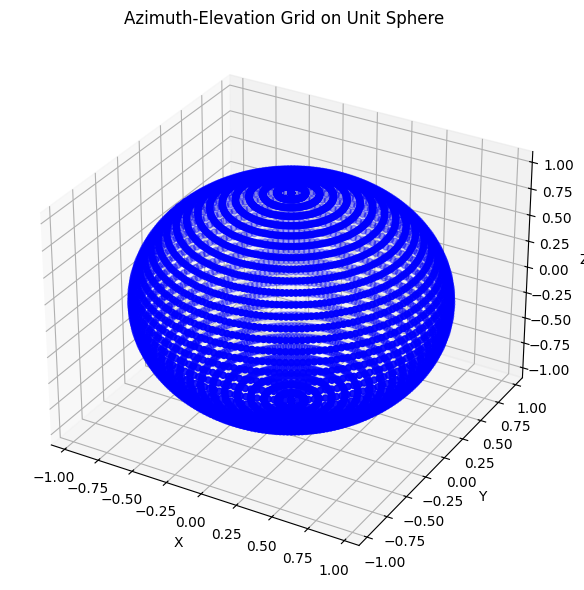

In [15]:
# Create HRIRReader object and plot an HRIR
new_hrir_reader = HRIRReader(new_sofa_path)

# Read azimuth and elevation angles from the dataset
az3, el3, r3 = unpack_coordinates(new_hrir_reader.get_listener_view(coord_type="spherical"))

# Plot the azimuth and elevation angles on a sphere by calling plot_points_on_sphere
plot_points_on_sphere(az3, el3)


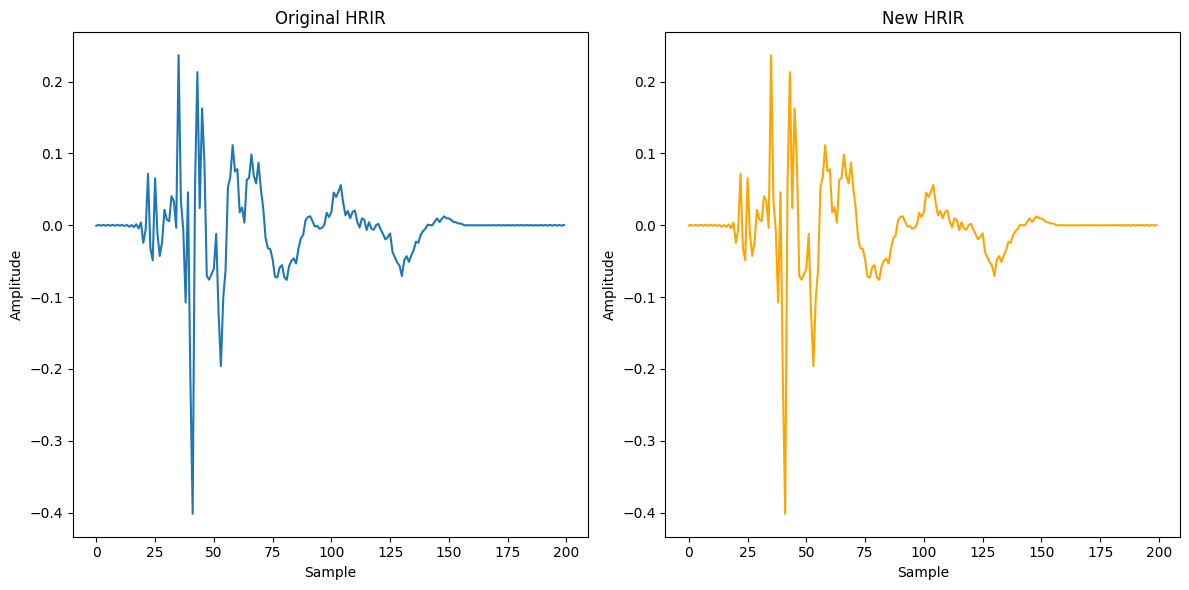

In [19]:
hrir_original = hrir_reader.ir_data
hrir_new = new_hrir_reader.ir_data

# Plot HRIRs for sanity check
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hrir_original[0, 0, :])
plt.title('Original HRIR')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.subplot(1, 2, 2)
plt.plot(hrir_new[0, 0, :], color='orange')
plt.title('New HRIR')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()
